# Layered Graph Analysis for Critical Component Identification
## Multi-Perspective Analysis of Distributed Publish-Subscribe Systems

**Objective:** Identify critical components across three distinct graph representations:

1. **Application-Level Layer**: Dependencies among applications (DEPENDS_ON)
2. **Infrastructure-Level Layer**: Node connectivity (CONNECTS_TO)
3. **Complete System View**: Full multi-layer graph with all relationships

This analysis reveals how criticality manifests differently at each architectural layer and enables comprehensive vulnerability assessment.

## 1. Setup and Imports

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Set
from dataclasses import dataclass
import networkx as nx
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

print("✓ Environment ready for layered analysis")

✓ Environment ready for layered analysis


## 2. Load Complete System Graph

We'll use the graph generated from the previous notebook or create a new one.

In [2]:
# For this demonstration, we'll create a synthetic graph
# In practice, load your existing graph here

def create_sample_system() -> nx.DiGraph:
    """
    Create a representative pub-sub system for layered analysis
    """
    G = nx.DiGraph()
    
    # Physical nodes
    nodes = ['Node1', 'Node2', 'Node3', 'Node4', 'Node5']
    for node in nodes:
        G.add_node(node, type='Node', name=node)
    
    # Node connectivity (CONNECTS_TO)
    node_connections = [
        ('Node1', 'Node2'), ('Node2', 'Node1'),
        ('Node2', 'Node3'), ('Node3', 'Node2'),
        ('Node3', 'Node4'), ('Node4', 'Node3'),
        ('Node1', 'Node5'), ('Node5', 'Node1'),
        ('Node4', 'Node5'), ('Node5', 'Node4')
    ]
    for src, tgt in node_connections:
        G.add_edge(src, tgt, type='CONNECTS_TO')
    
    # Brokers
    brokers = ['Broker1', 'Broker2']
    for i, broker in enumerate(brokers, 1):
        G.add_node(broker, type='Broker', name=broker)
        G.add_edge(broker, f'Node{i}', type='RUNS_ON')
    
    # Topics
    topics = ['payment/orders', 'user/events', 'metrics/system', 
              'notification/alerts', 'inventory/updates']
    for i, topic in enumerate(topics, 1):
        topic_id = f'T{i}'
        G.add_node(topic_id, type='Topic', name=topic,
                   durability='PERSISTENT' if 'payment' in topic or 'inventory' in topic else 'TRANSIENT_LOCAL',
                   reliability='RELIABLE' if 'payment' in topic else 'BEST_EFFORT')
        broker = brokers[i % 2]
        G.add_edge(broker, topic_id, type='ROUTES')
    
    # Applications
    apps = [
        ('PaymentService', 'Node1', ['T1'], ['T2', 'T5']),
        ('UserService', 'Node2', ['T2'], ['T1', 'T4']),
        ('MetricsCollector', 'Node3', ['T3'], ['T1', 'T2', 'T5']),
        ('NotificationService', 'Node3', ['T4'], ['T2', 'T5']),
        ('InventoryService', 'Node4', ['T5'], ['T1']),
        ('APIGateway', 'Node1', [], ['T1', 'T2', 'T3', 'T4', 'T5']),
        ('LogAggregator', 'Node5', [], ['T3']),
        ('AnalyticsEngine', 'Node5', [], ['T3', 'T5'])
    ]
    
    for app_name, node, publishes, subscribes in apps:
        G.add_node(app_name, type='Application', name=app_name)
        G.add_edge(app_name, node, type='RUNS_ON')
        
        for topic in publishes:
            G.add_edge(app_name, topic, type='PUBLISHES_TO')
        
        for topic in subscribes:
            G.add_edge(app_name, topic, type='SUBSCRIBES_TO')
    
    # Create DEPENDS_ON relationships
    for app1, _, publishes, _ in apps:
        for topic in publishes:
            for app2, _, _, subscribes in apps:
                if app1 != app2 and topic in subscribes:
                    G.add_edge(app2, app1, type='DEPENDS_ON')
    
    return G

# Create complete system graph
complete_graph = create_sample_system()

print("Complete System Graph Statistics:")
print(f"  Total nodes: {complete_graph.number_of_nodes()}")
print(f"  Total edges: {complete_graph.number_of_edges()}")
print(f"\nNode types:")
type_counts = {}
for node, data in complete_graph.nodes(data=True):
    node_type = data.get('type', 'Unknown')
    type_counts[node_type] = type_counts.get(node_type, 0) + 1
for node_type, count in sorted(type_counts.items()):
    print(f"    {node_type}: {count}")

Complete System Graph Statistics:
  Total nodes: 20
  Total edges: 66

Node types:
    Application: 8
    Broker: 2
    Node: 5
    Topic: 5


## 3. Layer Extraction Functions

Extract specific layers from the complete graph based on node types and edge types.

In [3]:
class LayerExtractor:
    """Extract different architectural layers from the complete system graph"""
    
    @staticmethod
    def extract_application_layer(graph: nx.DiGraph) -> nx.DiGraph:
        """
        Extract application-level layer showing dependencies among applications
        
        Includes:
        - Application nodes
        - DEPENDS_ON edges (application dependencies)
        """
        app_graph = nx.DiGraph()
        
        # Add application nodes
        for node, data in graph.nodes(data=True):
            if data.get('type') == 'Application':
                app_graph.add_node(node, **data)
        
        # Add DEPENDS_ON edges between applications
        for src, tgt, edge_data in graph.edges(data=True):
            if (edge_data.get('type') == 'DEPENDS_ON' and 
                src in app_graph and tgt in app_graph):
                app_graph.add_edge(src, tgt, **edge_data)
        
        return app_graph
    
    @staticmethod
    def extract_infrastructure_layer(graph: nx.DiGraph) -> nx.DiGraph:
        """
        Extract infrastructure-level layer showing physical node connectivity
        
        Includes:
        - Node (physical/virtual machine) nodes
        - CONNECTS_TO edges (network connectivity)
        """
        infra_graph = nx.DiGraph()
        
        # Add physical nodes
        for node, data in graph.nodes(data=True):
            if data.get('type') == 'Node':
                infra_graph.add_node(node, **data)
        
        # Add CONNECTS_TO edges between nodes
        for src, tgt, edge_data in graph.edges(data=True):
            if (edge_data.get('type') == 'CONNECTS_TO' and 
                src in infra_graph and tgt in infra_graph):
                infra_graph.add_edge(src, tgt, **edge_data)
        
        return infra_graph
    
    @staticmethod
    def extract_messaging_layer(graph: nx.DiGraph) -> nx.DiGraph:
        """
        Extract messaging layer showing pub-sub communication patterns
        
        Includes:
        - Application, Topic, and Broker nodes
        - PUBLISHES_TO, SUBSCRIBES_TO, ROUTES edges
        """
        msg_graph = nx.DiGraph()
        
        # Add relevant nodes
        for node, data in graph.nodes(data=True):
            if data.get('type') in ['Application', 'Topic', 'Broker']:
                msg_graph.add_node(node, **data)
        
        # Add messaging edges
        for src, tgt, edge_data in graph.edges(data=True):
            edge_type = edge_data.get('type')
            if (edge_type in ['PUBLISHES_TO', 'SUBSCRIBES_TO', 'ROUTES'] and
                src in msg_graph and tgt in msg_graph):
                msg_graph.add_edge(src, tgt, **edge_data)
        
        return msg_graph

# Extract layers
extractor = LayerExtractor()

app_layer = extractor.extract_application_layer(complete_graph)
infra_layer = extractor.extract_infrastructure_layer(complete_graph)
msg_layer = extractor.extract_messaging_layer(complete_graph)

print("Layer Extraction Summary:")
print(f"\nApplication Layer:")
print(f"  Nodes: {app_layer.number_of_nodes()} applications")
print(f"  Edges: {app_layer.number_of_edges()} dependencies")

print(f"\nInfrastructure Layer:")
print(f"  Nodes: {infra_layer.number_of_nodes()} physical nodes")
print(f"  Edges: {infra_layer.number_of_edges()} connections")

print(f"\nMessaging Layer:")
print(f"  Nodes: {msg_layer.number_of_nodes()}")
print(f"  Edges: {msg_layer.number_of_edges()}")

print(f"\nComplete System:")
print(f"  Nodes: {complete_graph.number_of_nodes()}")
print(f"  Edges: {complete_graph.number_of_edges()}")

Layer Extraction Summary:

Application Layer:
  Nodes: 8 applications
  Edges: 18 dependencies

Infrastructure Layer:
  Nodes: 5 physical nodes
  Edges: 10 connections

Messaging Layer:
  Nodes: 15
  Edges: 28

Complete System:
  Nodes: 20
  Edges: 66


## 4. Criticality Analysis Engine

Compute topological metrics for each layer independently.

In [4]:
class CriticalityAnalyzer:
    """
    Analyze criticality using topological metrics:
    C_score(v) = α·C_B^norm(v) + β·AP(v) + γ·I(v)
    """
    
    def __init__(self, alpha=0.4, beta=0.3, gamma=0.3):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
    
    def analyze_layer(self, graph: nx.DiGraph, layer_name: str) -> pd.DataFrame:
        """
        Perform comprehensive criticality analysis on a graph layer
        """
        if graph.number_of_nodes() == 0:
            return pd.DataFrame()
        
        print(f"\nAnalyzing {layer_name}...")
        
        # Compute centrality metrics
        centralities = self._compute_centralities(graph)
        
        # Find articulation points
        articulation_points = self._find_articulation_points(graph)
        
        # Calculate impact scores
        impact_scores = self._calculate_impact_scores(graph)
        
        # Build results DataFrame
        results = []
        for node in graph.nodes():
            betweenness = centralities['betweenness'][node]
            is_ap = node in articulation_points
            impact = impact_scores[node]
            
            composite = self._calculate_composite_score(
                betweenness, is_ap, impact
            )
            
            results.append({
                'node': node,
                'name': graph.nodes[node].get('name', node),
                'type': graph.nodes[node].get('type', 'Unknown'),
                'degree': centralities['degree'][node],
                'betweenness': betweenness,
                'closeness': centralities['closeness'][node],
                'pagerank': centralities['pagerank'][node],
                'is_articulation_point': is_ap,
                'impact_score': impact,
                'composite_criticality': composite,
                'layer': layer_name
            })
        
        df = pd.DataFrame(results)
        df = df.sort_values('composite_criticality', ascending=False)
        
        print(f"  ✓ Analyzed {len(df)} components")
        print(f"  ✓ Articulation points: {len(articulation_points)}")
        print(f"  ✓ Avg criticality: {df['composite_criticality'].mean():.4f}")
        
        return df
    
    def _compute_centralities(self, graph: nx.DiGraph) -> Dict:
        """Compute all centrality metrics"""
        return {
            'degree': nx.degree_centrality(graph),
            'betweenness': nx.betweenness_centrality(graph, normalized=True),
            'closeness': nx.closeness_centrality(graph) if nx.is_weakly_connected(graph) 
                        else {n: 0 for n in graph.nodes()},
            'pagerank': nx.pagerank(graph, max_iter=100)
        }
    
    def _find_articulation_points(self, graph: nx.DiGraph) -> Set:
        """Find articulation points (cut vertices)"""
        undirected = graph.to_undirected()
        return set(nx.articulation_points(undirected))
    
    def _calculate_impact_scores(self, graph: nx.DiGraph) -> Dict[str, float]:
        """
        Calculate impact scores: I(v) = 1 - |R(G-v)| / |R(G)|
        Using sampling for performance
        """
        original_reachable = self._count_reachable_pairs(graph)
        
        if original_reachable == 0:
            return {node: 0.0 for node in graph.nodes()}
        
        impact_scores = {}
        nodes = list(graph.nodes())
        
        # Sample nodes for large graphs
        sample_size = min(len(nodes), 20)
        sampled = np.random.choice(nodes, sample_size, replace=False) if len(nodes) > sample_size else nodes
        
        for node in sampled:
            test_graph = graph.copy()
            test_graph.remove_node(node)
            new_reachable = self._count_reachable_pairs(test_graph)
            impact_scores[node] = 1.0 - (new_reachable / original_reachable)
        
        # Estimate for non-sampled nodes
        if len(nodes) > sample_size:
            avg_impact = np.mean(list(impact_scores.values()))
            centralities = self._compute_centralities(graph)
            for node in graph.nodes():
                if node not in impact_scores:
                    impact_scores[node] = min(1.0, centralities['betweenness'][node] * avg_impact * 1.5)
        
        return impact_scores
    
    def _count_reachable_pairs(self, graph: nx.DiGraph) -> int:
        """Count reachable vertex pairs |R(G)|"""
        count = 0
        for source in graph.nodes():
            try:
                count += len(nx.descendants(graph, source))
            except:
                continue
        return count
    
    def _calculate_composite_score(self, betweenness: float, 
                                   is_ap: bool, impact: float) -> float:
        """
        Calculate: C_score(v) = α·C_B^norm(v) + β·AP(v) + γ·I(v)
        """
        ap_value = 1.0 if is_ap else 0.0
        score = (self.alpha * betweenness + 
                self.beta * ap_value + 
                self.gamma * impact)
        return min(1.0, max(0.0, score))

# Initialize analyzer
analyzer = CriticalityAnalyzer(alpha=0.4, beta=0.3, gamma=0.3)

print("✓ Criticality analyzer initialized")
print(f"  Weights: α={analyzer.alpha}, β={analyzer.beta}, γ={analyzer.gamma}")

✓ Criticality analyzer initialized
  Weights: α=0.4, β=0.3, γ=0.3


## 5. Layer-by-Layer Analysis

### 5.1 Application-Level Layer Analysis

In [5]:
# Analyze application layer
app_analysis = analyzer.analyze_layer(app_layer, "Application Layer")

print("\n" + "="*80)
print("APPLICATION LAYER - CRITICAL COMPONENTS")
print("="*80)
print("\nTop 5 Critical Applications:")
print(app_analysis[['name', 'composite_criticality', 'betweenness', 
                     'is_articulation_point', 'impact_score']].head().to_string(index=False))

# Identify key dependencies
print("\nKey Insights:")
if len(app_analysis) > 0:
    most_critical = app_analysis.iloc[0]
    print(f"  • Most critical: {most_critical['name']} (score: {most_critical['composite_criticality']:.4f})")
    
    ap_count = app_analysis['is_articulation_point'].sum()
    if ap_count > 0:
        print(f"  • Articulation points: {ap_count} applications are SPOFs")
        aps = app_analysis[app_analysis['is_articulation_point']]['name'].tolist()
        print(f"    → {', '.join(aps[:3])}")
    
    high_impact = app_analysis[app_analysis['impact_score'] > 0.3]
    print(f"  • High-impact components: {len(high_impact)} applications")


Analyzing Application Layer...
  ✓ Analyzed 8 components
  ✓ Articulation points: 1
  ✓ Avg criticality: 0.1449

APPLICATION LAYER - CRITICAL COMPONENTS

Top 5 Critical Applications:
               name  composite_criticality  betweenness  is_articulation_point  impact_score
   MetricsCollector               0.468356     0.154762                   True      0.354839
        UserService               0.197542     0.130952                  False      0.483871
     PaymentService               0.139939     0.059524                  False      0.387097
   InventoryService               0.106298     0.023810                  False      0.322581
NotificationService               0.101536     0.011905                  False      0.322581

Key Insights:
  • Most critical: MetricsCollector (score: 0.4684)
  • Articulation points: 1 applications are SPOFs
    → MetricsCollector
  • High-impact components: 5 applications


### 5.2 Infrastructure-Level Layer Analysis

In [6]:
# Analyze infrastructure layer
infra_analysis = analyzer.analyze_layer(infra_layer, "Infrastructure Layer")

print("\n" + "="*80)
print("INFRASTRUCTURE LAYER - CRITICAL COMPONENTS")
print("="*80)
print("\nCritical Infrastructure Nodes:")
print(infra_analysis[['name', 'composite_criticality', 'betweenness', 
                       'is_articulation_point', 'impact_score']].to_string(index=False))

print("\nKey Insights:")
if len(infra_analysis) > 0:
    most_critical = infra_analysis.iloc[0]
    print(f"  • Most critical node: {most_critical['name']} (score: {most_critical['composite_criticality']:.4f})")
    
    ap_count = infra_analysis['is_articulation_point'].sum()
    if ap_count > 0:
        print(f"  • Infrastructure SPOFs: {ap_count} nodes")
        aps = infra_analysis[infra_analysis['is_articulation_point']]['name'].tolist()
        print(f"    → {', '.join(aps)}")
    
    # Network connectivity analysis
    avg_degree = infra_analysis['degree'].mean()
    print(f"  • Average node connectivity: {avg_degree:.2f}")
    print(f"  • Network density: {nx.density(infra_layer):.4f}")


Analyzing Infrastructure Layer...
  ✓ Analyzed 5 components
  ✓ Articulation points: 0
  ✓ Avg criticality: 0.1867

INFRASTRUCTURE LAYER - CRITICAL COMPONENTS

Critical Infrastructure Nodes:
 name  composite_criticality  betweenness  is_articulation_point  impact_score
Node1               0.186667     0.166667                  False           0.4
Node2               0.186667     0.166667                  False           0.4
Node3               0.186667     0.166667                  False           0.4
Node4               0.186667     0.166667                  False           0.4
Node5               0.186667     0.166667                  False           0.4

Key Insights:
  • Most critical node: Node1 (score: 0.1867)
  • Average node connectivity: 1.00
  • Network density: 0.5000


### 5.3 Complete System View Analysis

In [7]:
# Analyze complete system
complete_analysis = analyzer.analyze_layer(complete_graph, "Complete System")

print("\n" + "="*80)
print("COMPLETE SYSTEM VIEW - CRITICAL COMPONENTS")
print("="*80)
print("\nTop 10 Critical Components (All Layers):")
print(complete_analysis[['name', 'type', 'composite_criticality', 'betweenness', 
                          'is_articulation_point', 'impact_score']].head(10).to_string(index=False))

print("\nKey Insights:")
if len(complete_analysis) > 0:
    # Most critical by type
    print("  • Most critical components by type:")
    for comp_type in ['Application', 'Node', 'Broker', 'Topic']:
        type_data = complete_analysis[complete_analysis['type'] == comp_type]
        if len(type_data) > 0:
            top = type_data.iloc[0]
            print(f"    - {comp_type}: {top['name']} (score: {top['composite_criticality']:.4f})")
    
    # Articulation points
    ap_by_type = complete_analysis[complete_analysis['is_articulation_point']].groupby('type').size()
    if len(ap_by_type) > 0:
        print("\n  • Articulation points by type:")
        for comp_type, count in ap_by_type.items():
            print(f"    - {comp_type}: {count}")


Analyzing Complete System...
  ✓ Analyzed 20 components
  ✓ Articulation points: 0
  ✓ Avg criticality: 0.0387

COMPLETE SYSTEM VIEW - CRITICAL COMPONENTS

Top 10 Critical Components (All Layers):
               name        type  composite_criticality  betweenness  is_articulation_point  impact_score
        UserService Application               0.078811     0.043860                  False      0.204225
   MetricsCollector Application               0.072505     0.049220                  False      0.176056
              Node1        Node               0.061196     0.036793                  False      0.154930
     PaymentService Application               0.059995     0.028509                  False      0.161972
              Node2        Node               0.057882     0.028509                  False      0.154930
   InventoryService Application               0.048718     0.021442                  False      0.133803
              Node3        Node               0.046898     0.022173

## 6. Cross-Layer Comparison

Compare how criticality manifests differently across layers.

In [8]:
# Combine all analyses
all_analyses = pd.concat([
    app_analysis,
    infra_analysis,
    complete_analysis
], ignore_index=True)

print("\n" + "="*80)
print("CROSS-LAYER COMPARISON")
print("="*80)

# Compare criticality distributions
print("\nCriticality Statistics by Layer:")
layer_stats = all_analyses.groupby('layer')['composite_criticality'].agg(['mean', 'std', 'max', 'min'])
print(layer_stats.to_string())

# Compare articulation points
print("\nArticulation Points by Layer:")
ap_by_layer = all_analyses.groupby('layer')['is_articulation_point'].sum()
for layer, count in ap_by_layer.items():
    total = len(all_analyses[all_analyses['layer'] == layer])
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {layer}: {count} ({percentage:.1f}% of layer)")

# Identify components critical across multiple layers
print("\nComponents Appearing in Multiple Layers:")
node_layer_count = all_analyses.groupby('node')['layer'].nunique()
multi_layer = node_layer_count[node_layer_count > 1]
if len(multi_layer) > 0:
    for node in multi_layer.index:
        node_data = all_analyses[all_analyses['node'] == node]
        layers = ', '.join(node_data['layer'].unique())
        avg_crit = node_data['composite_criticality'].mean()
        print(f"  {node}: {layers} (avg criticality: {avg_crit:.4f})")


CROSS-LAYER COMPARISON

Criticality Statistics by Layer:
                          mean       std       max       min
layer                                                       
Application Layer     0.144854  0.140781  0.468356  0.048387
Complete System       0.038725  0.020401  0.078811  0.010563
Infrastructure Layer  0.186667  0.000000  0.186667  0.186667

Articulation Points by Layer:
  Application Layer: 1 (12.5% of layer)
  Complete System: 0 (0.0% of layer)
  Infrastructure Layer: 0 (0.0% of layer)

Components Appearing in Multiple Layers:
  APIGateway: Application Layer, Complete System (avg criticality: 0.0400)
  AnalyticsEngine: Application Layer, Complete System (avg criticality: 0.0400)
  InventoryService: Application Layer, Complete System (avg criticality: 0.0775)
  LogAggregator: Application Layer, Complete System (avg criticality: 0.0400)
  MetricsCollector: Application Layer, Complete System (avg criticality: 0.2704)
  Node1: Infrastructure Layer, Complete System (av

## 7. Visualizations

### 7.1 Layer Comparison Dashboard

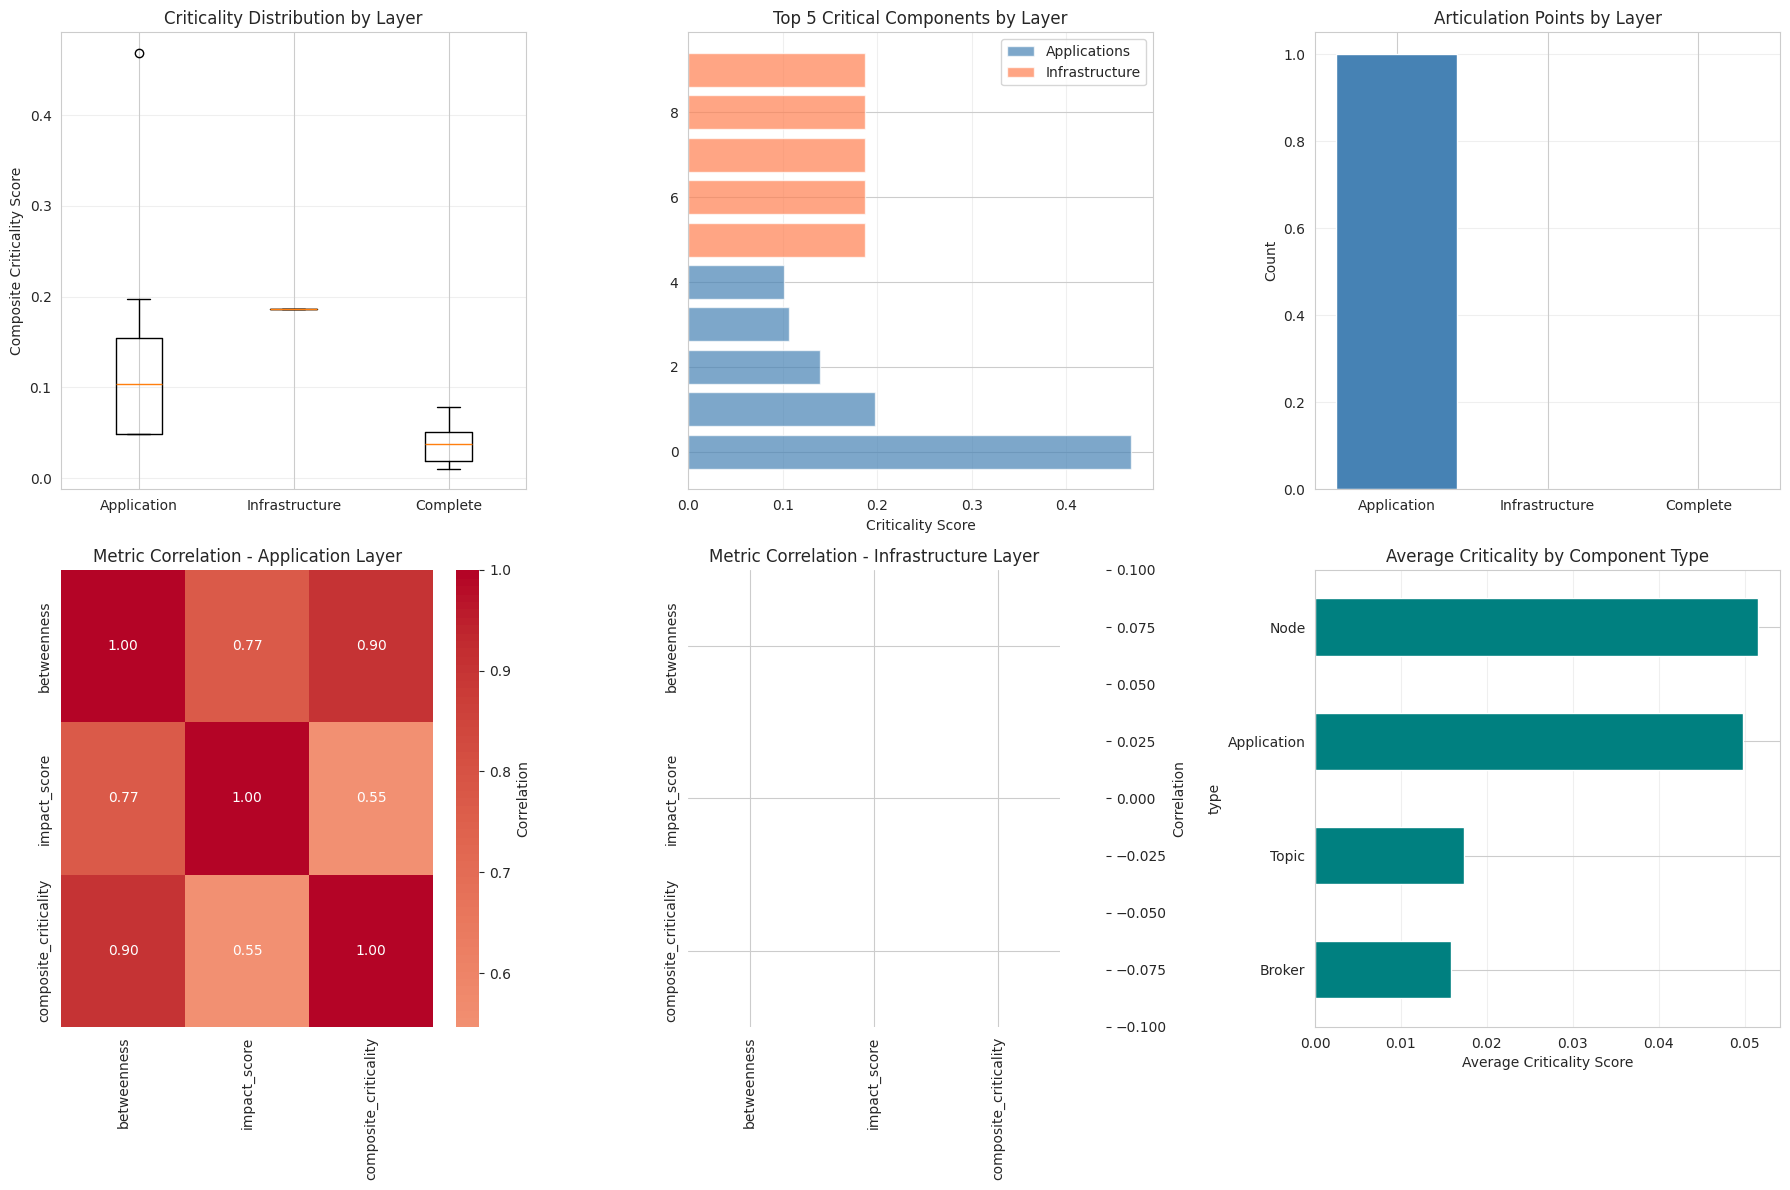

✓ Layer comparison dashboard generated


In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Criticality distribution by layer
ax = axes[0, 0]
layer_order = ['Application Layer', 'Infrastructure Layer', 'Complete System']
layer_data = [all_analyses[all_analyses['layer'] == l]['composite_criticality'].values 
              for l in layer_order if l in all_analyses['layer'].values]
layer_labels = [l.replace(' Layer', '').replace('Complete System', 'Complete') 
                for l in layer_order if l in all_analyses['layer'].values]
ax.boxplot(layer_data, labels=layer_labels)
ax.set_ylabel('Composite Criticality Score')
ax.set_title('Criticality Distribution by Layer')
ax.grid(True, alpha=0.3, axis='y')

# 2. Top critical components comparison
ax = axes[0, 1]
top_app = app_analysis.head(5) if len(app_analysis) > 0 else pd.DataFrame()
top_infra = infra_analysis.head(5) if len(infra_analysis) > 0 else pd.DataFrame()
if len(top_app) > 0:
    ax.barh(range(len(top_app)), top_app['composite_criticality'], 
            color='steelblue', alpha=0.7, label='Applications')
if len(top_infra) > 0:
    y_offset = len(top_app) if len(top_app) > 0 else 0
    ax.barh(range(y_offset, y_offset + len(top_infra)), top_infra['composite_criticality'],
            color='coral', alpha=0.7, label='Infrastructure')
ax.set_xlabel('Criticality Score')
ax.set_title('Top 5 Critical Components by Layer')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# 3. Articulation points by layer
ax = axes[0, 2]
ap_counts = []
for layer in layer_order:
    if layer in all_analyses['layer'].values:
        count = all_analyses[all_analyses['layer'] == layer]['is_articulation_point'].sum()
        ap_counts.append(count)
ax.bar(layer_labels, ap_counts, color=['steelblue', 'coral', 'green'][:len(ap_counts)])
ax.set_ylabel('Count')
ax.set_title('Articulation Points by Layer')
ax.grid(True, alpha=0.3, axis='y')

# 4. Metric correlation - Application Layer
ax = axes[1, 0]
if len(app_analysis) > 0:
    metrics = ['betweenness', 'impact_score', 'composite_criticality']
    corr = app_analysis[metrics].corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax,
                cbar_kws={'label': 'Correlation'})
    ax.set_title('Metric Correlation - Application Layer')
else:
    ax.text(0.5, 0.5, 'No data', ha='center', va='center')

# 5. Metric correlation - Infrastructure Layer
ax = axes[1, 1]
if len(infra_analysis) > 0:
    corr = infra_analysis[metrics].corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax,
                cbar_kws={'label': 'Correlation'})
    ax.set_title('Metric Correlation - Infrastructure Layer')
else:
    ax.text(0.5, 0.5, 'No data', ha='center', va='center')

# 6. Component type distribution in complete system
ax = axes[1, 2]
if len(complete_analysis) > 0:
    type_criticality = complete_analysis.groupby('type')['composite_criticality'].mean().sort_values()
    type_criticality.plot(kind='barh', ax=ax, color='teal')
    ax.set_xlabel('Average Criticality Score')
    ax.set_title('Average Criticality by Component Type')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('layered_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Layer comparison dashboard generated")

### 7.2 Graph Visualizations for Each Layer


Generating layer visualizations...



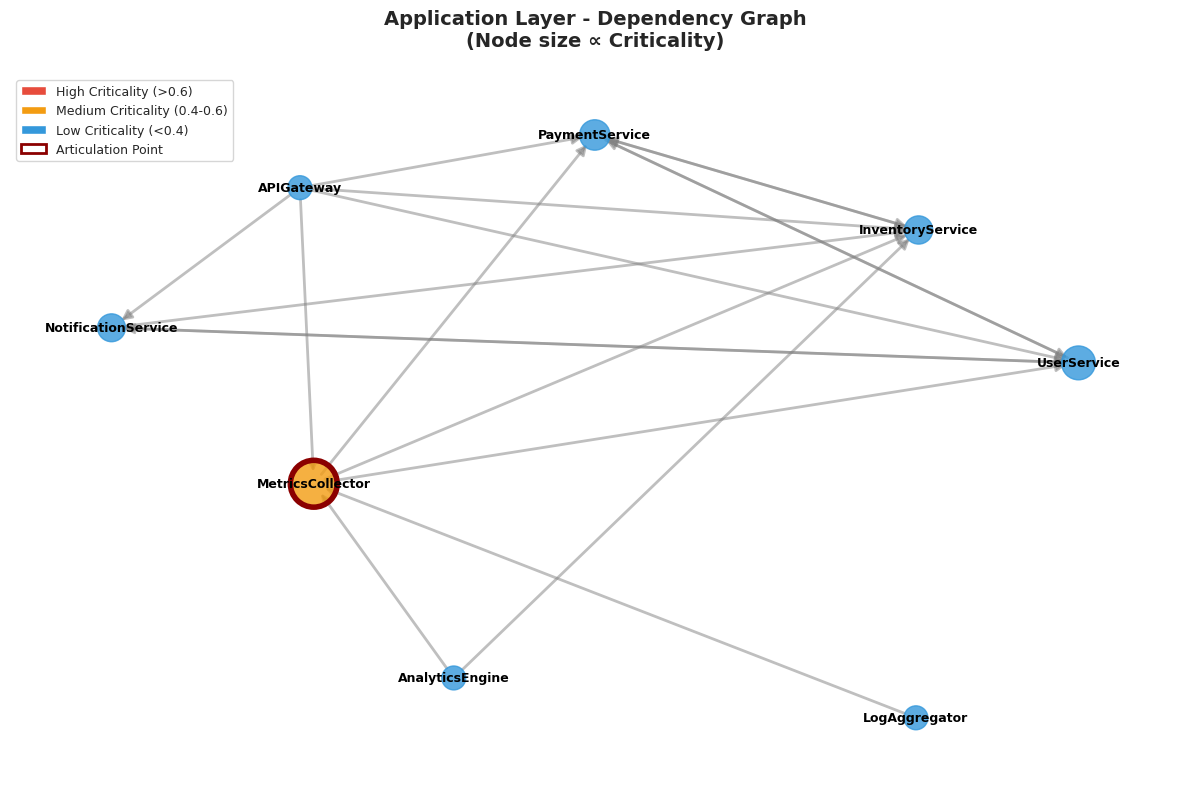

✓ Saved application_layer_-_dependency_graph.png


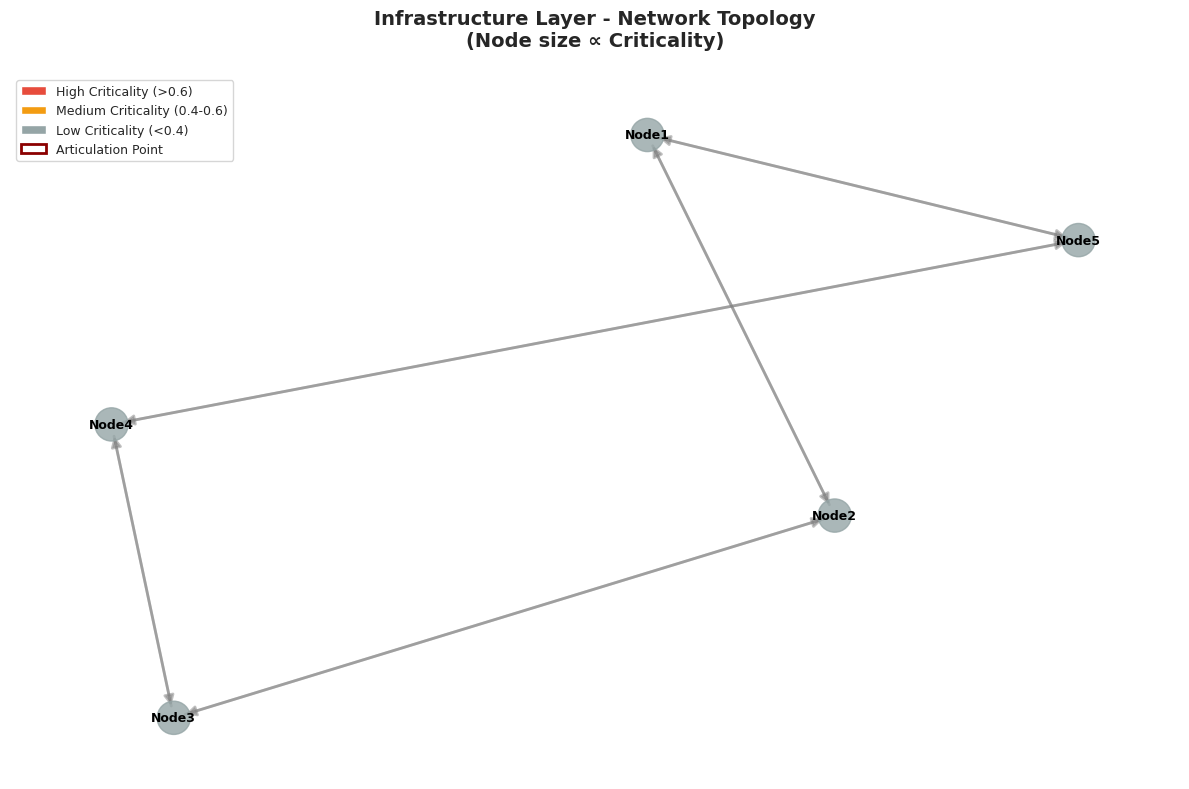

✓ Saved infrastructure_layer_-_network_topology.png


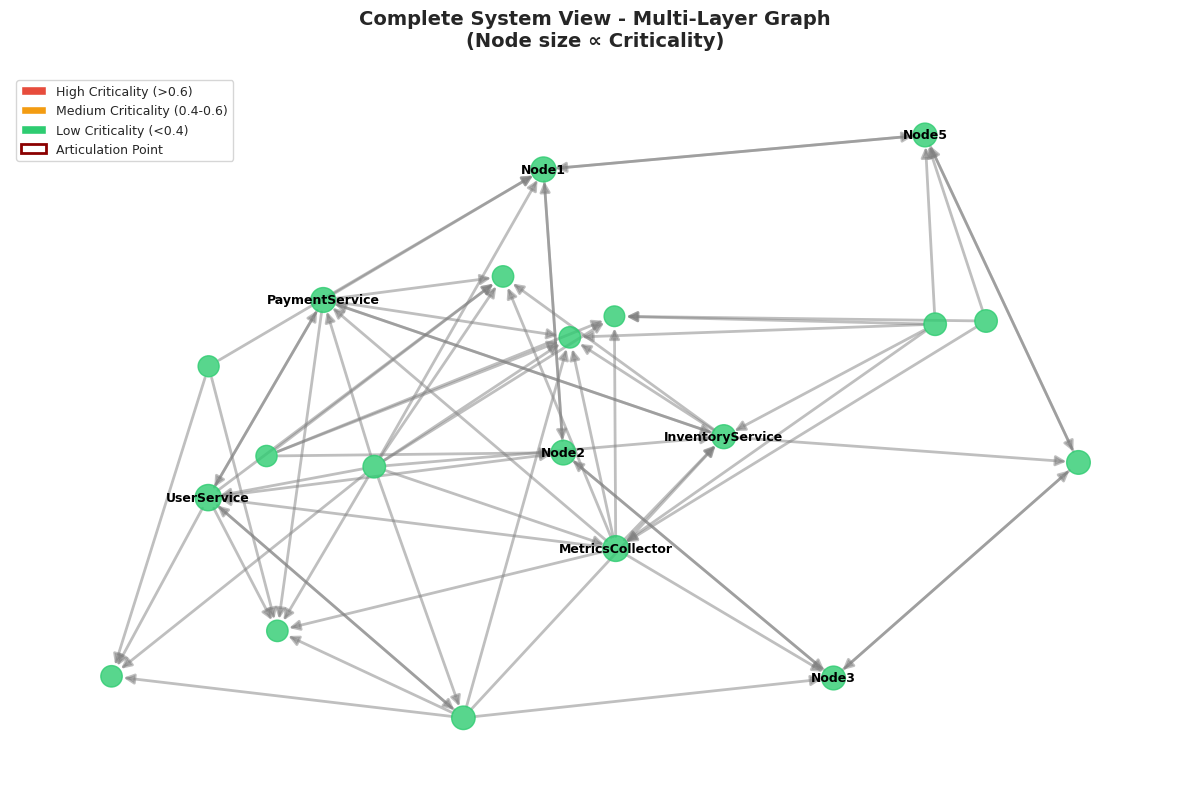

✓ Saved complete_system_view_-_multi-layer_graph.png


In [10]:
def visualize_layer_graph(graph: nx.DiGraph, analysis_df: pd.DataFrame, 
                          title: str, node_color: str = 'steelblue'):
    """
    Visualize a graph layer with criticality-based node sizing
    """
    if graph.number_of_nodes() == 0:
        print(f"No nodes to visualize for {title}")
        return
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Layout
    if graph.number_of_nodes() <= 10:
        pos = nx.spring_layout(graph, k=2, iterations=50, seed=42)
    else:
        pos = nx.kamada_kawai_layout(graph)
    
    # Node sizes based on criticality
    criticality_map = dict(zip(analysis_df['node'], analysis_df['composite_criticality']))
    node_sizes = [criticality_map.get(node, 0.1) * 2000 + 200 for node in graph.nodes()]
    
    # Node colors
    node_colors_list = []
    for node in graph.nodes():
        if criticality_map.get(node, 0) > 0.6:
            node_colors_list.append('#e74c3c')  # Red for high criticality
        elif criticality_map.get(node, 0) > 0.4:
            node_colors_list.append('#f39c12')  # Orange for medium
        else:
            node_colors_list.append(node_color)  # Default color
    
    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, 
                          node_size=node_sizes,
                          node_color=node_colors_list,
                          alpha=0.8,
                          ax=ax)
    
    # Highlight articulation points
    ap_nodes = analysis_df[analysis_df['is_articulation_point']]['node'].tolist()
    if ap_nodes:
        ap_in_graph = [n for n in ap_nodes if n in graph.nodes()]
        if ap_in_graph:
            ap_sizes = [criticality_map.get(node, 0.1) * 2000 + 200 for node in ap_in_graph]
            nx.draw_networkx_nodes(graph, pos,
                                  nodelist=ap_in_graph,
                                  node_size=ap_sizes,
                                  node_color='none',
                                  edgecolors='darkred',
                                  linewidths=4,
                                  ax=ax)
    
    # Draw edges
    nx.draw_networkx_edges(graph, pos,
                          edge_color='gray',
                          alpha=0.5,
                          arrows=True,
                          arrowsize=15,
                          arrowstyle='-|>',
                          width=2,
                          ax=ax)
    
    # Labels for top nodes
    top_nodes = analysis_df.head(min(8, len(analysis_df)))['node'].tolist()
    labels = {node: graph.nodes[node].get('name', node) for node in top_nodes if node in graph.nodes()}
    nx.draw_networkx_labels(graph, pos, labels, font_size=9, font_weight='bold', ax=ax)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#e74c3c', label='High Criticality (>0.6)'),
        Patch(facecolor='#f39c12', label='Medium Criticality (0.4-0.6)'),
        Patch(facecolor=node_color, label='Low Criticality (<0.4)'),
        Patch(facecolor='white', edgecolor='darkred', linewidth=2, label='Articulation Point')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=9)
    
    ax.set_title(f'{title}\n(Node size ∝ Criticality)', fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')
    
    plt.tight_layout()
    filename = title.replace(' ', '_').lower() + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved {filename}")

# Visualize each layer
print("\nGenerating layer visualizations...\n")

visualize_layer_graph(app_layer, app_analysis, 
                     "Application Layer - Dependency Graph", '#3498db')

visualize_layer_graph(infra_layer, infra_analysis, 
                     "Infrastructure Layer - Network Topology", '#95a5a6')

visualize_layer_graph(complete_graph, complete_analysis, 
                     "Complete System View - Multi-Layer Graph", '#2ecc71')

## 8. Cross-Layer Impact Analysis

Analyze how failures propagate across layers.

In [11]:
def analyze_cross_layer_impact(complete_graph: nx.DiGraph, 
                               complete_analysis: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze how component failures impact other layers
    """
    cross_impacts = []
    
    # For each infrastructure node, find affected applications
    for node, data in complete_graph.nodes(data=True):
        if data.get('type') != 'Node':
            continue
        
        # Find applications running on this node
        affected_apps = []
        for src, tgt, edge_data in complete_graph.in_edges(node, data=True):
            if (edge_data.get('type') == 'RUNS_ON' and 
                complete_graph.nodes[src].get('type') == 'Application'):
                affected_apps.append(src)
        
        # Find brokers on this node
        affected_brokers = []
        for src, tgt, edge_data in complete_graph.in_edges(node, data=True):
            if (edge_data.get('type') == 'RUNS_ON' and 
                complete_graph.nodes[src].get('type') == 'Broker'):
                affected_brokers.append(src)
        
        # Calculate cascading impact
        cascading_apps = set()
        for app in affected_apps:
            # Find apps that depend on this app
            for dependent, _, edge_data in complete_graph.in_edges(app, data=True):
                if edge_data.get('type') == 'DEPENDS_ON':
                    cascading_apps.add(dependent)
        
        node_crit = complete_analysis[complete_analysis['node'] == node]['composite_criticality'].iloc[0] if len(complete_analysis[complete_analysis['node'] == node]) > 0 else 0
        
        cross_impacts.append({
            'infrastructure_node': node,
            'infrastructure_criticality': node_crit,
            'directly_affected_apps': len(affected_apps),
            'affected_brokers': len(affected_brokers),
            'cascading_apps': len(cascading_apps),
            'total_app_impact': len(affected_apps) + len(cascading_apps),
            'cross_layer_risk_score': (len(affected_apps) + len(affected_brokers) * 2 + len(cascading_apps)) * node_crit
        })
    
    df = pd.DataFrame(cross_impacts)
    df = df.sort_values('cross_layer_risk_score', ascending=False)
    return df

# Perform cross-layer analysis
cross_layer_df = analyze_cross_layer_impact(complete_graph, complete_analysis)

print("\n" + "="*80)
print("CROSS-LAYER IMPACT ANALYSIS")
print("="*80)
print("\nInfrastructure nodes ranked by cross-layer risk:")
print(cross_layer_df.to_string(index=False))

print("\nKey Findings:")
if len(cross_layer_df) > 0:
    highest_risk = cross_layer_df.iloc[0]
    print(f"  • Highest risk node: {highest_risk['infrastructure_node']}")
    print(f"    - Directly affects {highest_risk['directly_affected_apps']} applications")
    print(f"    - Cascading impact on {highest_risk['cascading_apps']} more applications")
    print(f"    - Total application impact: {highest_risk['total_app_impact']}")
    print(f"    - Cross-layer risk score: {highest_risk['cross_layer_risk_score']:.4f}")


CROSS-LAYER IMPACT ANALYSIS

Infrastructure nodes ranked by cross-layer risk:
infrastructure_node  infrastructure_criticality  directly_affected_apps  affected_brokers  cascading_apps  total_app_impact  cross_layer_risk_score
              Node1                    0.061196                       2                 1               4                 6                0.489570
              Node2                    0.057882                       1                 1               4                 5                0.405177
              Node3                    0.046898                       2                 0               4                 6                0.281385
              Node4                    0.045338                       1                 0               5                 6                0.272029
              Node5                    0.046410                       2                 0               0                 2                0.092820

Key Findings:
  • Highest risk n

## 9. Summary Report

Generate comprehensive findings across all layers.

In [12]:
print("\n" + "="*80)
print("LAYERED CRITICALITY ANALYSIS - COMPREHENSIVE REPORT")
print("="*80)

print("\n1. EXECUTIVE SUMMARY")
print("-" * 80)
print(f"Analysis performed on {complete_graph.number_of_nodes()} components across 3 layers")
print(f"Total dependencies: {complete_graph.number_of_edges()}")

print("\n2. LAYER STATISTICS")
print("-" * 80)
for layer_name, layer_graph, layer_df in [
    ('Application Layer', app_layer, app_analysis),
    ('Infrastructure Layer', infra_layer, infra_analysis),
    ('Complete System', complete_graph, complete_analysis)
]:
    print(f"\n{layer_name}:")
    print(f"  Components: {layer_graph.number_of_nodes()}")
    print(f"  Relationships: {layer_graph.number_of_edges()}")
    if len(layer_df) > 0:
        print(f"  Avg Criticality: {layer_df['composite_criticality'].mean():.4f}")
        print(f"  Max Criticality: {layer_df['composite_criticality'].max():.4f}")
        print(f"  Articulation Points: {layer_df['is_articulation_point'].sum()}")
        most_critical = layer_df.iloc[0]
        print(f"  Most Critical: {most_critical['name']} ({most_critical['composite_criticality']:.4f})")

print("\n3. CRITICAL COMPONENTS BY LAYER")
print("-" * 80)

if len(app_analysis) > 0:
    print("\nApplication Layer (Top 3):")
    for i, row in app_analysis.head(3).iterrows():
        ap_marker = "[AP]" if row['is_articulation_point'] else ""
        print(f"  {i+1}. {row['name']} {ap_marker}")
        print(f"     Score: {row['composite_criticality']:.4f} | Impact: {row['impact_score']:.4f}")

if len(infra_analysis) > 0:
    print("\nInfrastructure Layer (All Nodes):")
    for i, row in infra_analysis.iterrows():
        ap_marker = "[AP]" if row['is_articulation_point'] else ""
        print(f"  {i+1}. {row['name']} {ap_marker}")
        print(f"     Score: {row['composite_criticality']:.4f} | Betweenness: {row['betweenness']:.4f}")

print("\n4. CROSS-LAYER VULNERABILITIES")
print("-" * 80)
if len(cross_layer_df) > 0:
    print("\nInfrastructure nodes with highest cross-layer risk:")
    for i, row in cross_layer_df.head(3).iterrows():
        print(f"\n  {row['infrastructure_node']}:")
        print(f"    • Direct app impact: {row['directly_affected_apps']}")
        print(f"    • Cascading impact: {row['cascading_apps']} apps")
        print(f"    • Risk score: {row['cross_layer_risk_score']:.4f}")

print("\n5. KEY RECOMMENDATIONS")
print("-" * 80)

recommendations = []

# Application layer recommendations
if len(app_analysis) > 0:
    app_aps = app_analysis[app_analysis['is_articulation_point']]
    if len(app_aps) > 0:
        recommendations.append(
            f"• CRITICAL: Implement redundancy for {len(app_aps)} application-level SPOFs: "
            f"{', '.join(app_aps['name'].head(3).tolist())}"
        )

# Infrastructure recommendations  
if len(infra_analysis) > 0:
    infra_aps = infra_analysis[infra_analysis['is_articulation_point']]
    if len(infra_aps) > 0:
        recommendations.append(
            f"• CRITICAL: Add network redundancy for infrastructure SPOFs: "
            f"{', '.join(infra_aps['name'].tolist())}"
        )

# Cross-layer recommendations
if len(cross_layer_df) > 0:
    high_risk = cross_layer_df[cross_layer_df['cross_layer_risk_score'] > 
                                cross_layer_df['cross_layer_risk_score'].quantile(0.75)]
    if len(high_risk) > 0:
        recommendations.append(
            f"• HIGH PRIORITY: Distribute applications across nodes to reduce concentration on: "
            f"{', '.join(high_risk['infrastructure_node'].head(2).tolist())}"
        )

# General recommendations
recommendations.extend([
    "• Establish automated failover mechanisms for all articulation points",
    "• Monitor high-criticality components with enhanced observability",
    "• Conduct regular disaster recovery drills for top 5 critical components",
    "• Review and optimize application dependencies to reduce coupling"
])

for rec in recommendations:
    print(f"\n{rec}")

print("\n" + "="*80)
print("END OF REPORT")
print("="*80)


LAYERED CRITICALITY ANALYSIS - COMPREHENSIVE REPORT

1. EXECUTIVE SUMMARY
--------------------------------------------------------------------------------
Analysis performed on 20 components across 3 layers
Total dependencies: 66

2. LAYER STATISTICS
--------------------------------------------------------------------------------

Application Layer:
  Components: 8
  Relationships: 18
  Avg Criticality: 0.1449
  Max Criticality: 0.4684
  Articulation Points: 1
  Most Critical: MetricsCollector (0.4684)

Infrastructure Layer:
  Components: 5
  Relationships: 10
  Avg Criticality: 0.1867
  Max Criticality: 0.1867
  Articulation Points: 0
  Most Critical: Node1 (0.1867)

Complete System:
  Components: 20
  Relationships: 66
  Avg Criticality: 0.0387
  Max Criticality: 0.0788
  Articulation Points: 0
  Most Critical: UserService (0.0788)

3. CRITICAL COMPONENTS BY LAYER
--------------------------------------------------------------------------------

Application Layer (Top 3):
  3. Metric

## 10. Export Results

In [13]:
# Export all analyses
app_analysis.to_csv('application_layer_analysis.csv', index=False)
infra_analysis.to_csv('infrastructure_layer_analysis.csv', index=False)
complete_analysis.to_csv('complete_system_analysis.csv', index=False)
cross_layer_df.to_csv('cross_layer_impact.csv', index=False)

# Export summary JSON
summary = {
    'layers': {
        'application': {
            'nodes': app_layer.number_of_nodes(),
            'edges': app_layer.number_of_edges(),
            'avg_criticality': float(app_analysis['composite_criticality'].mean()) if len(app_analysis) > 0 else 0,
            'articulation_points': int(app_analysis['is_articulation_point'].sum()) if len(app_analysis) > 0 else 0
        },
        'infrastructure': {
            'nodes': infra_layer.number_of_nodes(),
            'edges': infra_layer.number_of_edges(),
            'avg_criticality': float(infra_analysis['composite_criticality'].mean()) if len(infra_analysis) > 0 else 0,
            'articulation_points': int(infra_analysis['is_articulation_point'].sum()) if len(infra_analysis) > 0 else 0
        },
        'complete': {
            'nodes': complete_graph.number_of_nodes(),
            'edges': complete_graph.number_of_edges(),
            'avg_criticality': float(complete_analysis['composite_criticality'].mean()),
            'articulation_points': int(complete_analysis['is_articulation_point'].sum())
        }
    },
    'top_critical_by_layer': {
        'application': app_analysis.head(5)[['name', 'composite_criticality']].to_dict('records') if len(app_analysis) > 0 else [],
        'infrastructure': infra_analysis.head(5)[['name', 'composite_criticality']].to_dict('records') if len(infra_analysis) > 0 else [],
        'complete': complete_analysis.head(10)[['name', 'type', 'composite_criticality']].to_dict('records')
    },
    'cross_layer_risks': cross_layer_df.head(5).to_dict('records') if len(cross_layer_df) > 0 else []
}

with open('layered_analysis_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n✓ Results exported successfully:")
print("  - application_layer_analysis.csv")
print("  - infrastructure_layer_analysis.csv")
print("  - complete_system_analysis.csv")
print("  - cross_layer_impact.csv")
print("  - layered_analysis_summary.json")
print("  - layered_analysis_dashboard.png")
print("  - application_layer_-_dependency_graph.png")
print("  - infrastructure_layer_-_network_topology.png")
print("  - complete_system_view_-_multi-layer_graph.png")


✓ Results exported successfully:
  - application_layer_analysis.csv
  - infrastructure_layer_analysis.csv
  - complete_system_analysis.csv
  - cross_layer_impact.csv
  - layered_analysis_summary.json
  - layered_analysis_dashboard.png
  - application_layer_-_dependency_graph.png
  - infrastructure_layer_-_network_topology.png
  - complete_system_view_-_multi-layer_graph.png


## Conclusion

This layered analysis reveals how criticality manifests differently across architectural perspectives:

### **Key Insights**

1. **Application Layer**: Identifies logical dependencies and application-level single points of failure through DEPENDS_ON relationships

2. **Infrastructure Layer**: Reveals network topology vulnerabilities and physical connectivity bottlenecks through CONNECTS_TO relationships

3. **Complete System**: Provides holistic view showing how logical and physical layers interact, revealing cross-layer vulnerabilities

4. **Cross-Layer Impact**: Quantifies cascading failure risks showing how infrastructure failures propagate to applications

### **Practical Applications**

- **Application Layer**: Guide service mesh design, API gateway placement, circuit breaker configuration
- **Infrastructure Layer**: Inform data center topology, network redundancy, disaster recovery planning
- **Complete System**: Comprehensive risk assessment, capacity planning, incident response prioritization
- **Cross-Layer**: Resource allocation, workload distribution, fault isolation strategies

By analyzing each layer independently and then synthesizing findings, this approach provides actionable insights for building resilient distributed systems.